<a href="https://colab.research.google.com/github/Arevalinchy/Image_Processing_Initiative/blob/main/IIPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IIP Proyect

Objective: To use disparity maps from stereoscopic images to improve the segmentation of these image 

Step 1: The first step consists in computing the disparity map itself

Disparity map: Is an image where its pixel has a value corresponding to the displacements of pixels from one image to the other on stereo images

Algorithm idea:
for each pixel of the image corresponding to the left eye (left image) 
find the corresponding pixel in the right image 
  
put the corresponding distance (displacement value) in the corresponding pixel of the map


The main problem is: how to put in correspondance pixels of two different images ?




In [4]:
!pip install opencv-python

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Part 1

## Making the stereoscopic image

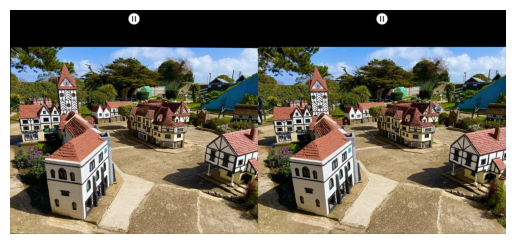

In [68]:
#we upload the image with the left side and right side 
img = cv.imread('img/stereoimage.jpg', cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [69]:
#taking the two stereocopic images
#Due to being matrices is simle to grab Regions Of Interes by giving the coordinates 
imgL = img[100:500,0:550] 
imgR = img[100:500,550:1200]

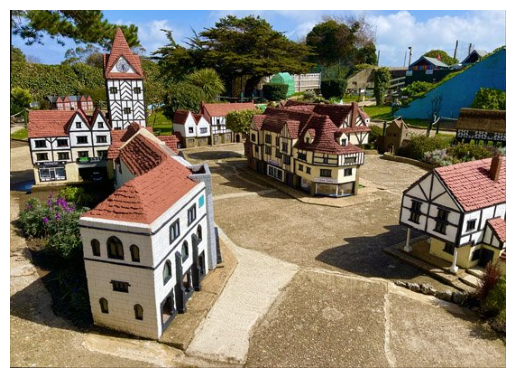

In [70]:
#Plotting the right one
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

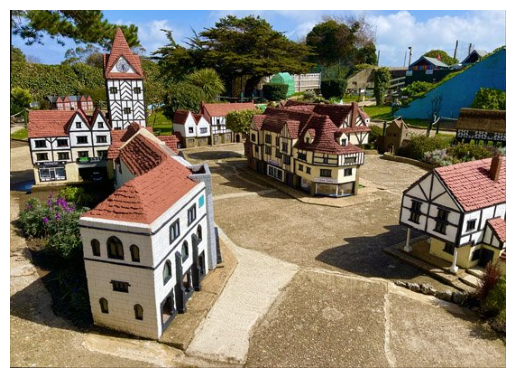

In [71]:
#Plotting the left one
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

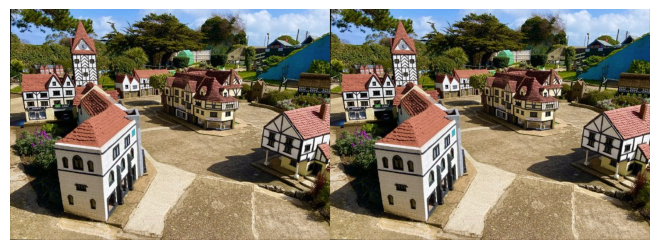

In [80]:
f = plt.figure()
f.add_subplot(1,2, 1,frameon=False)
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')
f.add_subplot(1,2, 2,frameon=False)
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()


## Making the red/Cyan image

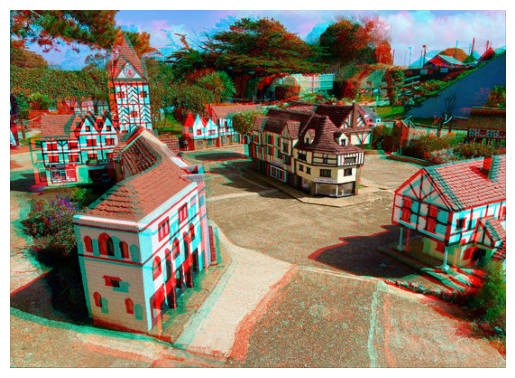

In [77]:
#We rip apart the color channels from the image

#Color channels for the left image
(Bl_Channel,Gl_Channel,Rl_Channel) = cv.split(imgL)

#Color channels for the right image
(Br_Channel,Gr_Channel,Rr_Channel) = cv.split(imgR)

#Even though we took all 3 channels from each image, we only need the red channel from 
#the left image and the blue and green channel from the right one. 

#now we make the Red/Cyan Analyph
RCA = cv.merge((Br_Channel,Gr_Channel,Rl_Channel))#Functions take independent channels and creates a single image!
plt.imshow(cv.cvtColor(RCA,cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



# Part 2

**Creating the disparity map**

The code bellow reveals disparity map for the two selected images. For the time being it looks in rough shape and not ideal at all

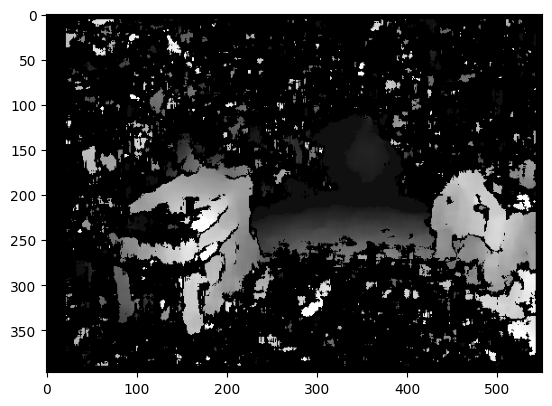

In [6]:
stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

Now we proceed to play with the matching block to make the image better

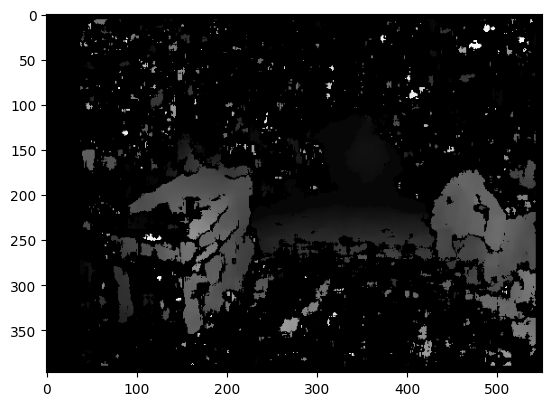

In [7]:
stereo = cv.StereoBM.create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

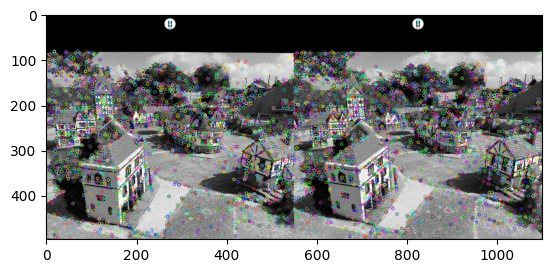

In [4]:
img = cv.imread('./img/stereoimage.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite('sift_keypoints.jpg',img)
plt.imshow(img)
plt.show()

Shift code


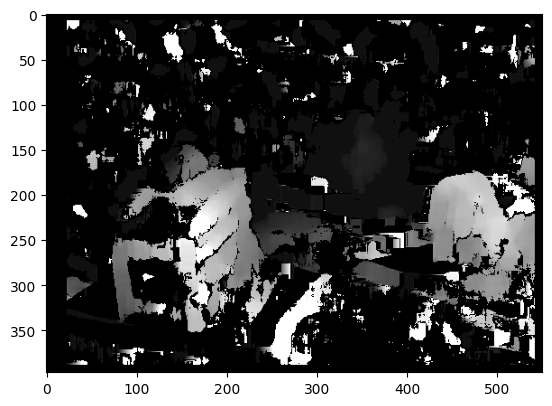

In [118]:
#cv.StereoBM.setPreFilterType()
stereo = cv.StereoBM.create(numDisparities=16, blockSize=17)
stereo.setPreFilterType(cv.STEREO_BM_PREFILTER_NORMALIZED_RESPONSE)
# pre_filter_type is an integer value representing the type of pre-filtering
# It can take one of the following values:
# cv.STEREO_BM_PREFILTER_NORMALIZED_RESPONSE: Normalize the response of the pre-filter
# cv.STEREO_BM_PREFILTER_XSOBEL: Use Sobel operator for pre-filtering in the horizontal direction
# cv.STEREO_BM_BASIC_PRESET: Use the basic pre-filtering preset
stereo.setPreFilterSize(77)
# pre_filter_size is an odd integer value representing the size of the pre-filtering window
# It determines the size of the window used for pre-filtering before stereo matching
# Larger pre-filter sizes can smooth the disparity map, while smaller sizes can preserve more details
# Experiment with different pre-filter sizes to see their effect on your stereo matching results

#stereo.setPreFilterType(0)

# pre_filter_type is an integer value representing the type of pre-filtering
# It can take one of the following values:
# cv2.STEREO_BM_PREFILTER_NORMALIZED_RESPONSE: Normalize the response of the pre-filter
# cv2.STEREO_BM_PREFILTER_XSOBEL: Use Sobel operator for pre-filtering in the horizontal direction
# cv2.STEREO_BM_BASIC_PRESET: Use the basic pre-filtering preset

# Experiment with different pre-filter types to see their effect on your stereo matching results

disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()



# Part 3

Segmentation algorithms can be classified into three categories :
- pixel based algorithms, for example histogram-based ones.
- edge based algorithm (most of the time, it corresponds to high pass filters)
- region based algorithm (watershed, split and merge, etc.)

In [ ]:
Kmeans

In [ ]:
import sklearn.cluster as skl
skl

#Every link that helps me survive the long and awaited development of the C.V. project >;)

https://learnopencv.com/depth-perception-using-stereo-camera-python-c/
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=filterspeckles#cv2.filterSpeckles
https://python.plainenglish.io/the-depth-ii-block-matching-d599e9372712
https://docs.opencv.org/3.4/d9/dba/classcv_1_1StereoBM.html
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html
https://docs.opencv.org/4.x/db/deb/tutorial_display_image.html

https://www.tutorialspoint.com/splitting-and-merging-channels-with-opencv-python
https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html
https://docs.opencv.org/4.x/d3/d47/group__imgproc__segmentation.html
https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html
https://matplotlib.org/stable/users/explain/colors/colormaps.
https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
https://www.statology.org/fig-add-subplot/
https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots